## Visualize the effect of reannotation of UTR

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [212]:
# UTR Stats

#Load 3prime UTR data as a dataframe
genome_assy_dir = os.path.normpath('/home/heineike/genomes/scer_20181114')
utr3p_fn = genome_assy_dir + os.sep + 'Nagalakshmi_2008_3UTRs_V64.gff3'

figsave_dir = os.path.normpath('/home/heineike/scratch/')

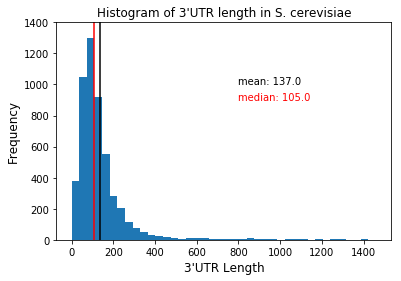

In [33]:
nag_UTRs = pd.read_table(utr3p_fn, skiprows=42, header = None)
nag_UTRs.columns = ['chromosome', 'source', 'type', 'start', 'end','score', 'strand', 'frame', 'attributes']
UTR_lengths = nag_UTRs['end']-nag_UTRs['start']

fig, ax = plt.subplots()
ymax = 1400
ax.hist(UTR_lengths, bins=40)
ax.set_ylim(0,ymax)
ax.set_xlabel("3'UTR Length", fontdict={'size':12})
ax.set_ylabel('Frequency', fontdict={'size':12})
ax.set_title("Histogram of 3'UTR length in S. cerevisiae")
dist_mean = np.mean(UTR_lengths)
dist_median = np.median(UTR_lengths)
ax.text(800,1000,'mean: {:0.1f}'.format(dist_mean), color='k')
ax.vlines(dist_mean,0,ymax, color='k')
ax.text(800,900, 'median: {:0.1f}'.format(dist_median), color = 'r')
ax.vlines(dist_median,0,ymax, color='r')

In [ ]:
#What percentage is above 400?

## Load metadata from count files in order to compare with and without 3'UTR

In [176]:
#extracts metadata from count files and stores as a dataframe
#also stores a file for each countdata folder 

data_dir = os.path.normpath("/home/heineike/rna_seq_data/20181024_KL_SC_PKA_Msn24_Rph1Gis1/dual_index/BMH_HES_02") + os.sep

spec = 'SC'


#Extract metadata from starLog.final.out

samples = os.listdir(data_dir + 'processed_data')

starLog_data_out_dict = {}
for sample in samples: 
    if sample.split('_')[0]==spec:
        #B15_S15_L001_R1_001.fastq.gz
        index_base = sample.split('_')[1]
        star_dir = os.path.normpath('star_out/B' + index_base + '_S' + str(int(index_base)) + '_L001_R1_001.fastq.gz') + os.sep

        starLog = pd.read_table(data_dir + 'processed_data' + os.sep + sample + os.sep + star_dir + 'starLog.final.out', index_col = 0, header = None).T

        ind_to_keep = [4,5]+list(range(7,21)) + list(range(22,26))+list(range(27,30))+[31,32]

        starLog_data_out = starLog[starLog.columns[ind_to_keep]]

        starLog_data_out_dict[sample] = starLog_data_out.values[0]

starLog_data_df = pd.DataFrame.from_dict(starLog_data_out_dict, orient='index', columns = starLog_data_out.columns)



#Get metadata from counts
UTR_params = ['orig','nag']

countfile_metadata_names = ["__no_feature", "__ambiguous", "__too_low_aQual", "__not_aligned", "__alignment_not_unique"]

#count_metadata = {}

metadata = starLog_data_df.copy()

for UTR_param in UTR_params:


    if UTR_param == 'nag':
        count_dir = data_dir + "counts_" + spec + '_UTR_' + UTR_param + os.sep

    elif UTR_param == 'orig': 
        count_dir = data_dir + "counts_" + spec + '_orig' + os.sep
    
    else: 
        raise ValueError('Bad UTR_param value')
        
    count_dirlist = os.listdir(count_dir)

    #Make dataframe to store all metadata
    #Make dict from sample to list of metadata


    count_metadata_UTR_dict = {}
    for counts_fname in count_dirlist: 
        if counts_fname.split('.')[-1]=='txt':  #only processes .txt files since the .csv will also be stored in this directory
            ind = counts_fname.split('.')[0].split(spec)[1][1:]
            sample = spec + '_' + ind
            read_counts = pd.read_table(count_dir + counts_fname, header = None, index_col=0)
            countfile_metadata = list(read_counts.loc[countfile_metadata_names,:].values.flatten())
            count_metadata_UTR_dict[sample] = countfile_metadata

    count_metadata_UTR = pd.DataFrame.from_dict(count_metadata_UTR_dict, orient='index', columns=[UTR_param + col for col in countfile_metadata_names])

    count_metadata_UTR.to_csv(count_dir + 'count_metadata.csv')
    
    metadata = metadata.merge(count_metadata_UTR, how = 'outer',left_index=True, right_index=True)
    
    #count_metadata[UTR_param] = count_metadata_UTR


#import my pre-sequencing metadata file and merge
metadata_preseq = pd.read_csv(os.path.normpath('/home/heineike/rna_seq_data/20181024_KL_SC_PKA_Msn24_Rph1Gis1/20181017_metadata_V2.csv'))
metadata_preseq['sample'] = metadata_preseq['Species'] + '_' + [str(ind)[-2:] for ind in metadata_preseq['I7 index']]


metadata = metadata.merge(metadata_preseq, how='left', left_index=True, right_on='sample')

#convert percentages of mapped reads and number of input reads
metadata['Uniquely mapped reads %'] = [float(item.split('%')[0]) for item in metadata['                        Uniquely mapped reads % |']]
metadata['Number of input reads'] = [int(item) for item in metadata['                          Number of input reads |']]

#make columns for pct of reads not assigned to gene features for various reasons
for UTR_param in UTR_params:
    metadata[UTR_param + ' pct not aligned to feature'] = metadata[UTR_param + '__no_feature'].divide(metadata['Number of input reads'])
    metadata[UTR_param + ' pct alignment not unique'] = metadata[UTR_param + '__alignment_not_unique'].divide(metadata['Number of input reads'])
    metadata[UTR_param + ' pct ambiguous'] = metadata[UTR_param + '__ambiguous'].divide(metadata['Number of input reads'])

metadata.to_csv(os.path.normpath('/home/heineike/rna_seq_data/20181024_KL_SC_PKA_Msn24_Rph1Gis1/20181017_metadata_V2_postseq_'+spec + '.csv'))


In [177]:
metadata.columns

Index(['                          Number of input reads |',
       '                      Average input read length |',
       '                   Uniquely mapped reads number |',
       '                        Uniquely mapped reads % |',
       '                          Average mapped length |',
       '                       Number of splices: Total |',
       '            Number of splices: Annotated (sjdb) |',
       '                       Number of splices: GT/AG |',
       '                       Number of splices: GC/AG |',
       '                       Number of splices: AT/AC |',
       '               Number of splices: Non-canonical |',
       '                      Mismatch rate per base, % |',
       '                         Deletion rate per base |',
       '                        Deletion average length |',
       '                        Insertion rate per base |',
       '                       Insertion average length |',
       '        Number of reads mapped t

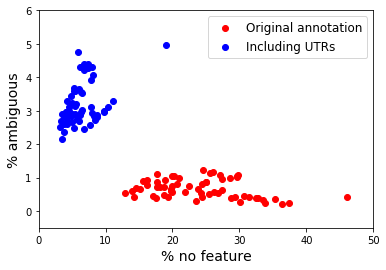

In [213]:
## Make this just plot S. cer

#PLot pct no feature v.s. pct alignment not unique for each species

#columns_to_view = ['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned', '__alignment_not_unique','long_name', 'pct not aligned to feature', 'pct alignment not unique', 'Number of input reads',  '                   Uniquely mapped reads number |', 'total_reads_w_features']
#metadata_df[columns_to_view]

fig, ax = plt.subplots(1,1)

#spec = 'SC'

colordict = {'orig': 'r', 'nag': 'b'}

for UTR_param in ['orig', 'nag']: 
    #metadata_df_spec = metadata_df[metadata_df['spec']==spec]
    ax.scatter(metadata[UTR_param + ' pct not aligned to feature']*100, metadata[UTR_param + ' pct ambiguous']*100, c = colordict[UTR_param])
    
ax.set_xlabel('% no feature', fontdict={'size':14})
ax.set_ylabel('% ambiguous', fontdict={'size':14})
ax.set_xlim([0,50])
ax.set_ylim([-0.5,6.0])
ax.legend(['Original annotation','Including UTRs'], fontsize=12)

fig.savefig(figsave_dir + os.sep + 'no_feat_v_ambig.svg')

In [214]:
UTR_param = 'nag'
print(min(metadata[UTR_param + ' pct not aligned to feature']*100))
print(max(metadata[UTR_param + ' pct not aligned to feature']*100))
print(np.mean(metadata[UTR_param + ' pct not aligned to feature']*100))

3.207340249296167
19.01044970907575
6.202748465186284


In [219]:
UTR_param = 'nag'
print(min(metadata[UTR_param + ' pct ambiguous']*100))
print(max(metadata[UTR_param + ' pct ambiguous']*100))
print(np.mean(metadata[UTR_param + ' pct ambiguous']*100))
print(np.std(metadata[UTR_param + ' pct ambiguous']*100))

2.1575243656965513
4.967237035291559
3.1823863538598665
0.6182172062186395


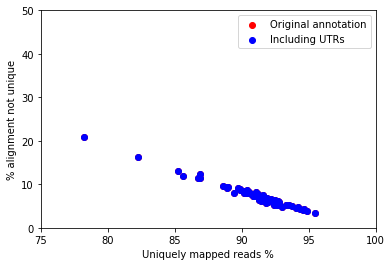

In [179]:
#when using the bluebee read counts directly, the pct alignment not unique is much higher.  Now using the same count command 
#and gff originating from the same source, they are aligned. 
fig, ax = plt.subplots(1,1)


colordict = {'orig': 'r', 'nag': 'b'}

for UTR_param in ['orig', 'nag']: 
    #metadata_df_spec = metadata_df[metadata_df['spec']==spec]
    ax.scatter(metadata['Uniquely mapped reads %'], metadata[UTR_param + ' pct alignment not unique']*100, c = colordict[UTR_param])
    
ax.set_xlabel('Uniquely mapped reads %')
ax.set_ylabel('% alignment not unique')
ax.set_xlim([75,100])
ax.set_ylim([0,50])
ax.legend(['Original annotation','Including UTRs'])


(0, 5500000)

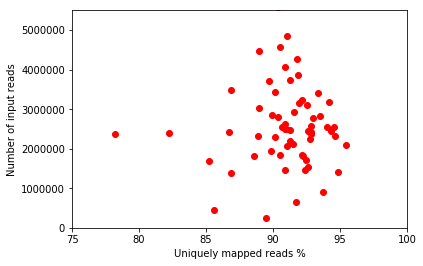

In [135]:
fig, ax = plt.subplots(1,1)


colordict = {'orig': 'r', 'nag': 'b'}

UTR_param = 'orig'

#metadata_df_spec = metadata_df[metadata_df['spec']==spec]
ax.scatter(metadata['Uniquely mapped reads %'], metadata['Number of input reads'], c = colordict[UTR_param])
           #metadata[UTR_param + ' pct alignment not unique'], c = colordict[UTR_param])
    
ax.set_xlabel('Uniquely mapped reads %')
ax.set_ylabel('Number of input reads')
ax.set_xlim([75,100])
ax.set_ylim([0,5500000])


In [149]:
#sample 3 and 78 have lower uniquely mapped read percentages. 
metadata['Uniquely mapped reads %'][metadata['Uniquely mapped reads %']<85]

SC_03    78.23
SC_78    82.23
Name: Uniquely mapped reads %, dtype: float64

In [147]:
print('Minimum number of reads {} \nMaximum number of reads {}'.format(min(metadata['Number of input reads']), 
                                                                       max(metadata['Number of input reads'])))

print('Minimum pct uniquely mapped {} \nMaximum pct uniquely mapped {}'.format(min(metadata['Uniquely mapped reads %']), 
                                                                       max(metadata['Uniquely mapped reads %'])))


Minimum number of reads 245709 
Maximum number of reads 5594439
Minimum pct uniquely mapped 78.23 
Maximum pct uniquely mapped 95.45


In [ ]:
#Metadata: Plot uniquely mapped reads v.s. total number of reads
#this would be better if I had condition, background and species labeled. 

fig, ax = plt.subplots(1,1)

colordict = {'SC': 'r', 'KL': 'b'}

for spec in ['SC', 'KL']: 
    metadata_df_spec = metadata_df[metadata_df['spec']==spec]
    unique_map_pct = metadata_df_spec['Uniquely mapped reads %']
    nreads = metadata_df_spec['Number of input reads']
    ax.scatter(unique_map_pct, nreads, color = colordict[spec])

ax.set_xlabel('pct uniquely mapped reads')
ax.set_ylabel('N reads')
ax.set_xlim([75,100])
ax.set_ylim([0,5500000])
ax.legend(['S. Cerevisiae','K. Lactis'])

In [34]:
# Scatter plot with original count data


In [ ]:
# Scatter plot with revised count data

In [ ]:
# Scatter plot with SC 400bp extension data

In [ ]:
# comparison of LFC with/without count data, 400bp extension 

In [ ]:
# Comparison of raw expression with/without count data, 400bp extension

In [ ]:
#Load metadata and countdata files

metadata_df = pd.read_csv(data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017\\20181017_metadata_V2_postseq.csv'), index_col = 0)
metadata_df.set_index('I7 index', inplace=True)

spec = 'SC'
countdata_df = pd.read_csv(data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017\\20181017_countdata_' + spec + '.csv'), index_col = 0)
countdata_df_preUTR = pd.read_csv(data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017\\pre_UTR\\20181017_countdata_' + spec + '_preUTR.csv'), index_col = 0)

In [ ]:
countdata_df_merged = countdata_df.merge(countdata_df_preUTR, how='inner', left_index=True, right_index=True, suffixes=('_UTR', '_preUTR'))

inds_to_check = {'7009': 'AS -drug',
                 '7013': 'AS +drug'}

fig, axarr = plt.subplots(2,1)

jj = 0
for ind,title in inds_to_check.items():
    ax = axarr[jj]
    ax.scatter(np.log(countdata_df_merged.loc[:,ind+'_preUTR']), np.log(countdata_df_merged.loc[:,ind+'_UTR']), alpha = 0.1)
    ax.set_xlabel(title + ' no UTR')
    ax.set_ylabel(title + ' UTR')
    jj = jj+1

In [ ]:

#         spec_index = read_counts.drop(labels = countfile_metadata_names,axis=0).index

#         spec_countdata = pd.DataFrame(index=spec_index)

#         countdata_df_dict[spec] = spec_countdata
        
#I7_index = [int('70' + str(sample_dir.split('_')[1]).zfill(2)) for sample_dir in raw_data_dirlist]

# #columns = ['spec', 'index'] + list(starLog.columns[ind_to_keep])
# #pd.DataFrame(index = index, columns = columns)
# metadata_df = pd.DataFrame(index = I7_index)


# countfile_metadata_names = ["__no_feature", "__ambiguous", "__too_low_aQual", "__not_aligned", "__alignment_not_unique"]


# #Make dataframe to store all count data by gene
# indices = {}

# #the first sample in the directory is a KL sample, the last one is an SC sample
# sample_dirs = {'KL': raw_data_dirlist[0], 
#             'SC': raw_data_dirlist[-1]}

# # read_counts_fnames = {'KL' : 'read_counts.txt',
# #                      'SC' : 'read_counts_UTR.txt'}

# read_counts_fname = 'read_counts_UTR.txt'

# countdata_df_dict = {}

# for spec, sample_dir in sample_dirs.items():

#     #Get index by species
    
#     #If the read count filenames are different use this: 
#     #read_counts_fname = read_counts_fnames[spec]

#     index_base = sample_dir.split('_')[1]
#     index = int('70' + index_base)

#     #Extract data from read_counts.txt
#     star_dir = os.path.normpath('star_out\\B' + index_base + '_S' + str(int(index_base)) + '_L001_R1_001.fastq.gz') + os.sep
#     print(star_dir)
#     read_counts = pd.read_table(raw_data_dir + sample_dir + os.sep + star_dir + read_counts_fname, header = None, index_col=0)
#     spec_index = read_counts.drop(labels = countfile_metadata_names,axis=0).index

#     spec_countdata = pd.DataFrame(index=spec_index)

#     countdata_df_dict[spec] = spec_countdata




# spec_list = []
# starLog_data_out_dict = {}
# read_counts_metadata_dict = {}

# for sample_dir in raw_data_dirlist: 
#     spec = sample_dir.split('_')[0]
#     spec_list.append(spec)

#     #If the read count filenames are different use this: 
#     #read_counts_fname = read_counts_fnames[spec]
    
#     index_base = sample_dir.split('_')[1]
#     index = int('70' + index_base)

#     #Extract metadata from starLog.final.out
#     star_dir = os.path.normpath('star_out\\B' + index_base + '_S' + str(int(index_base)) + '_L001_R1_001.fastq.gz') + os.sep

#     starLog = pd.read_table(raw_data_dir + sample_dir + os.sep + star_dir + 'starLog.final.out', index_col = 0, header = None).T

#     ind_to_keep = [4,5]+list(range(7,21)) + list(range(22,26))+list(range(27,30))+[31,32]

#     starLog_data_out = starLog[starLog.columns[ind_to_keep]]

#     starLog_data_out_dict[index] = starLog_data_out.values[0]


#     #Extract data from read_counts.txt or read_counts_UTR.txt
#     read_counts = pd.read_table(raw_data_dir + sample_dir + os.sep + star_dir + read_counts_fname, header = None, index_col=0)
    
#     read_counts_metadata_dict[index] = list(read_counts.loc[countfile_metadata_names][1].values) + list(read_counts.drop(labels = countfile_metadata_names,axis=0).sum().values)
    
#     #store data in correct dataframe
#     countdata_df = countdata_df_dict[spec]
#     countdata_df[index] = read_counts.drop(labels = countfile_metadata_names,axis=0)
    
    

# #add species to metadata dataframe
# metadata_df['spec'] = spec_list

# #integrate metadata from starLog
# starLog_data_df = pd.DataFrame.from_dict(starLog_data_out_dict, orient='index', columns = starLog_data_out.columns)
# metadata_df = metadata_df.merge(starLog_data_df, left_index=True, right_index=True, how = 'inner')

# #integrate metadata from count files
# read_counts_metadata_df = pd.DataFrame.from_dict(read_counts_metadata_dict, orient = 'index', columns = countfile_metadata_names + ['total_reads_w_features'] )
# metadata_df = metadata_df.merge(read_counts_metadata_df, left_index=True, right_index=True, how = 'inner')

# #import my pre-sequencing metadata file and merge
# metadata_preseq = pd.read_csv(data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017\\20181017_metadata_V2.csv'))

# metadata_df = metadata_df.merge(metadata_preseq, left_index = True, right_on = 'I7 index', how = 'left')

# #convert percentages of mapped reads and number of input reads
# metadata_df['Uniquely mapped reads %'] = [float(item.split('%')[0]) for item in metadata_df['                        Uniquely mapped reads % |']]
# metadata_df['Number of input reads'] = [int(item) for item in metadata_df['                          Number of input reads |']]

# #make columns for pct of reads not assigned to gene features for various reasons
# metadata_df['pct not aligned to feature'] = metadata_df['__no_feature'].divide(metadata_df['Number of input reads'])
# metadata_df['pct alignment not unique'] = metadata_df['__alignment_not_unique'].divide(metadata_df['Number of input reads'])
# metadata_df['pct ambiguous'] = metadata_df['__ambiguous'].divide(metadata_df['Number of input reads'])

# metadata_df.to_csv(data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017\\20181017_metadata_V2p2_postseq.csv'))

# for spec, countdata_df in countdata_df_dict.items():
#     countdata_df.to_csv(data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017\\20181017_countdata_' + spec + '.csv'))


In [ ]:
#Load metadata and countdata files

metadata_df = pd.read_csv(data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017\\20181017_metadata_V2p2_postseq.csv'), index_col = 0)
metadata_df.set_index('I7 index', inplace=True)

countdata_df_dict = {}

for spec in ['SC', 'KL']: 
    countdata_df_dict[spec] = pd.read_csv(data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017\\20181017_countdata_' + spec + '.csv'), index_col = 0)
    

In [ ]:
#adjust datasets based on QC: 

#remove SC: 
#7077 low counts, lots of unmapped reads and isn't clustering well 
#7073 name mix up - not sure what the sample is. clusters with WT, RG/M24/RGM24, +drug

#remove from countdata
countdata_postQC = {}
column_drop_dict = {'SC': ['7077','7073']}

for spec, countdata_df in countdata_df_dict.items():
    countdata_postQC_spec = countdata_df.copy()
    
    #only drops columns if the species has columns to drop
    if spec in column_drop_dict.keys():
        countdata_postQC_spec = countdata_df.drop(columns = column_drop_dict[spec])       
    countdata_postQC[spec] = countdata_postQC_spec
    countdata_postQC_spec.to_csv(data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017\\20181017_countdata_postQC_' + spec + '.csv')) 
    
#remove from metadata
all_samples_to_drop = [int(ind) for ind in list(chain.from_iterable(list(column_drop_dict.values())))]
metadata_postQC = metadata_df.drop(index = all_samples_to_drop)

metadata_postQC.to_csv(data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017\\20181017_metadata_postQC.csv'))   


In [ ]:
#Load metadata and countdata (post QC) 

metadata_postQC = pd.read_csv(data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017\\20181017_metadata_postQC.csv'), index_col = 0)

countdata_postQC = {}

for spec in ['SC', 'KL']: 
    countdata_postQC[spec] = pd.read_csv(data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017\\20181017_countdata_postQC_' + spec + '.csv'), index_col = 0)


In [159]:
3326567 + 341409

3667976

In [166]:
 89.72 + 9.21 + .18 + .12 + .77

100.00000000000001

In [161]:
metadata.loc['SC_01',:]

                          Number of input reads |       3707558
                      Average input read length |            50
                   Uniquely mapped reads number |       3326578
                        Uniquely mapped reads % |        89.72%
                          Average mapped length |         49.53
                       Number of splices: Total |          9567
            Number of splices: Annotated (sjdb) |          6700
                       Number of splices: GT/AG |          9561
                       Number of splices: GC/AG |             2
                       Number of splices: AT/AC |             1
               Number of splices: Non-canonical |             3
                      Mismatch rate per base, % |         0.68%
                         Deletion rate per base |         0.00%
                        Deletion average length |          1.14
                        Insertion rate per base |         0.00%
                       Insertion average

In [190]:
orig = pd.read_table('/home/heineike/rna_seq_data/20181024_KL_SC_PKA_Msn24_Rph1Gis1/dual_index/BMH_HES_02/counts_SC_orig/read_counts_orig_SC_13.txt', names = ['genename','counts'], index_col=0)
nag = pd.read_table('/home/heineike/rna_seq_data/20181024_KL_SC_PKA_Msn24_Rph1Gis1/dual_index/BMH_HES_02/counts_SC_UTR_nag/read_counts_UTR_nag_SC_13.txt', names = ['genename','counts'], index_col=0)


In [205]:
SC_13_merge = orig.merge(nag, how='outer', left_index = True, right_index=True, suffixes=['_orig','_nag'])
SC_13_diff = SC_13_merge['counts_nag']-SC_13_merge['counts_orig']

#CYC7 = YEL039C
#PYK2 = YOR347C
#EGO4 = YNR034W-A
#
#

SC_13_merge.loc[['YEL039C','YOR347C', 'YNR034W-A', 'YNR034W'],:]

,counts_orig,counts_nag
genename,,
YEL039C,114,278
YOR347C,121,121
YNR034W-A,1026,1501
YNR034W,40,90
